In [174]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [386]:
base_path = "/home/jinjinjara1022/"

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

weather_observed_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1.csv")
weather_observed_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

In [387]:
weather_observed_data_2_jeju = weather_observed_data_2[weather_observed_data_2['location'] == 'Jeju']

In [388]:
# 'hour' 열 추가
weather_observed_data_2_jeju['hour'] = pd.to_datetime(weather_observed_data_2_jeju['ts'], unit='s').dt.hour

# 'date' 열 추가
weather_observed_data_2_jeju['date'] = pd.to_datetime(weather_observed_data_2_jeju['ts'], unit='s').dt.date

/tmp/ipykernel_1335641/804909180.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  weather_observed_data_2_jeju['hour'] = pd.to_datetime(weather_observed_data_2_jeju['ts'], unit='s').dt.hour
/tmp/ipykernel_1335641/804909180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_observed_data_2_jeju['hour'] = pd.to_datetime(weather_observed_data_2_jeju['ts'], unit='s').dt.hour
/tmp/ipykernel_1335641/804909180.py:5: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing stri

In [389]:
weather_observed_data_2_jeju

,location,ts,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow,hour,date
22673,Jeju,1709218851,93.0,7.18,7.18,7.18,76.0,1023.0,8.23,341.0,0.11,0.0,15,2024-02-29
22674,Jeju,1709220660,75.0,7.96,7.96,7.96,66.0,1022.0,3.09,340.0,0.0,0.0,15,2024-02-29
22675,Jeju,1709222452,95.0,6.87,6.87,6.87,77.0,1023.0,8.98,340.0,0.0,0.0,16,2024-02-29
22676,Jeju,1709224270,75.0,7.96,7.96,7.96,66.0,1022.0,4.63,340.0,0.0,0.0,16,2024-02-29
22677,Jeju,1709226056,96.0,6.15,6.15,6.15,71.0,1024.0,9.52,342.0,0.77,0.0,17,2024-02-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34007,Jeju,1729600283,75.0,21.96,21.96,21.96,83.0,1016.0,6.17,270.0,0.53,0.0,12,2024-10-22
34008,Jeju,1729602067,75.0,19.96,19.96,19.96,94.0,1016.0,10.8,300.0,0.53,0.0,13,2024-10-22
34009,Jeju,1729603843,75.0,19.96,19.96,19.96,88.0,1016.0,10.8,290.0,0.48,0.0,13,2024-10-22
34010,Jeju,1729605674,100.0,20.29,20.29,20.29,92.0,1016.0,9.07,299.0,0.48,0.0,14,2024-10-22


In [390]:
weather_observed_data_2_jeju = weather_observed_data_2_jeju.drop_duplicates(subset=['date', 'hour'], keep='first')

In [391]:
weather_observed_data_2_jeju

,location,ts,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow,hour,date
22673,Jeju,1709218851,93.0,7.18,7.18,7.18,76.0,1023.0,8.23,341.0,0.11,0.0,15,2024-02-29
22675,Jeju,1709222452,95.0,6.87,6.87,6.87,77.0,1023.0,8.98,340.0,0.0,0.0,16,2024-02-29
22677,Jeju,1709226056,96.0,6.15,6.15,6.15,71.0,1024.0,9.52,342.0,0.77,0.0,17,2024-02-29
22679,Jeju,1709229638,97.0,5.79,5.79,5.79,67.0,1024.0,9.4,340.0,0.0,0.0,18,2024-02-29
22681,Jeju,1709233254,53.0,5.19,5.19,5.19,69.0,1024.0,9.94,340.0,0.0,0.0,19,2024-02-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34002,Jeju,1729591263,97.0,21.83,21.83,21.83,86.0,1015.0,5.65,280.0,0.0,0.0,10,2024-10-22
34004,Jeju,1729594848,97.0,21.77,21.77,21.77,87.0,1015.0,6.01,271.0,0.0,0.0,11,2024-10-22
34006,Jeju,1729598477,99.0,21.67,21.67,21.67,91.0,1015.0,7.09,282.0,0.18,0.0,12,2024-10-22
34008,Jeju,1729602067,75.0,19.96,19.96,19.96,94.0,1016.0,10.8,300.0,0.53,0.0,13,2024-10-22


In [392]:
# 'hour' 열 추가
jeju_power_market_day_ahead['hour'] = pd.to_datetime(jeju_power_market_day_ahead['ts'], unit='s').dt.hour

# 'date' 열 추가
jeju_power_market_day_ahead['date'] = pd.to_datetime(jeju_power_market_day_ahead['ts'], unit='s').dt.date

In [393]:
jeju_power_market_day_ahead

,ts,하루전가격(원/kWh),hour,date
0,1709218800,107.39,15,2024-02-29
1,1709222400,107.39,16,2024-02-29
2,1709226000,95.30,17,2024-02-29
3,1709229600,87.89,18,2024-02-29
4,1709233200,0.00,19,2024-02-29
...,...,...,...,...
5660,1729594800,156.68,11,2024-10-22
5661,1729598400,152.54,12,2024-10-22
5662,1729602000,106.92,13,2024-10-22
5663,1729605600,150.97,14,2024-10-22


In [394]:
df = pd.merge(weather_observed_data_2_jeju, jeju_power_market_day_ahead, on=['hour', 'date'], how='left')

In [395]:
df

,location,ts_x,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow,hour,date,ts_y,하루전가격(원/kWh)
0,Jeju,1709218851,93.0,7.18,7.18,7.18,76.0,1023.0,8.23,341.0,0.11,0.0,15,2024-02-29,1709218800,107.39
1,Jeju,1709222452,95.0,6.87,6.87,6.87,77.0,1023.0,8.98,340.0,0.0,0.0,16,2024-02-29,1709222400,107.39
2,Jeju,1709226056,96.0,6.15,6.15,6.15,71.0,1024.0,9.52,342.0,0.77,0.0,17,2024-02-29,1709226000,95.30
3,Jeju,1709229638,97.0,5.79,5.79,5.79,67.0,1024.0,9.4,340.0,0.0,0.0,18,2024-02-29,1709229600,87.89
4,Jeju,1709233254,53.0,5.19,5.19,5.19,69.0,1024.0,9.94,340.0,0.0,0.0,19,2024-02-29,1709233200,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,Jeju,1729591263,97.0,21.83,21.83,21.83,86.0,1015.0,5.65,280.0,0.0,0.0,10,2024-10-22,1729591200,156.68
5660,Jeju,1729594848,97.0,21.77,21.77,21.77,87.0,1015.0,6.01,271.0,0.0,0.0,11,2024-10-22,1729594800,156.68
5661,Jeju,1729598477,99.0,21.67,21.67,21.67,91.0,1015.0,7.09,282.0,0.18,0.0,12,2024-10-22,1729598400,152.54
5662,Jeju,1729602067,75.0,19.96,19.96,19.96,94.0,1016.0,10.8,300.0,0.53,0.0,13,2024-10-22,1729602000,106.92


In [396]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      5664 non-null   object 
 1   ts_x          5664 non-null   object 
 2   cloud         5664 non-null   object 
 3   temp          5664 non-null   object 
 4   temp_max      5664 non-null   object 
 5   temp_min      5664 non-null   object 
 6   humidity      5664 non-null   object 
 7   ground_press  5664 non-null   object 
 8   wind_speed    5664 non-null   object 
 9   wind_dir      5664 non-null   object 
 10  rain          5664 non-null   object 
 11  snow          5664 non-null   object 
 12  hour          5664 non-null   int32  
 13  date          5664 non-null   object 
 14  ts_y          5664 non-null   int64  
 15  하루전가격(원/kWh)  5664 non-null   float64
dtypes: float64(1), int32(1), int64(1), object(13)
memory usage: 686.0+ KB


In [397]:
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      5664 non-null   object 
 1   ts_x          5664 non-null   object 
 2   cloud         5664 non-null   object 
 3   temp          5664 non-null   object 
 4   temp_max      5664 non-null   object 
 5   temp_min      5664 non-null   object 
 6   humidity      5664 non-null   object 
 7   ground_press  5664 non-null   object 
 8   wind_speed    5664 non-null   object 
 9   wind_dir      5664 non-null   object 
 10  rain          5664 non-null   object 
 11  snow          5664 non-null   object 
 12  hour          5664 non-null   int32  
 13  date          5664 non-null   object 
 14  ts_y          5664 non-null   int64  
 15  하루전가격(원/kWh)  5664 non-null   float64
 16  sin_hour      5664 non-null   float64
 17  cos_hour      5664 non-null   float64
dtypes: float64(3), int32(1), int

In [401]:
df = df.drop(['location', 'ts_x', 'ts_y', 'hour', 'date'], axis=1)
df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [402]:
df = df.astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cloud         5664 non-null   float64
 1   temp          5664 non-null   float64
 2   temp_max      5664 non-null   float64
 3   temp_min      5664 non-null   float64
 4   humidity      5664 non-null   float64
 5   ground_press  5664 non-null   float64
 6   wind_speed    5664 non-null   float64
 7   wind_dir      5664 non-null   float64
 8   rain          5664 non-null   float64
 9   snow          5664 non-null   float64
 10  sin_hour      5664 non-null   float64
 11  cos_hour      5664 non-null   float64
 12  하루전가격(원/kWh)  5664 non-null   float64
dtypes: float64(13)
memory usage: 575.4 KB


In [403]:
tmp_df = df[df.columns]

In [404]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# StandardScaler 초기화
scaler = StandardScaler()

# 10, 11, 12 열 제외한 나머지 열 선택
columns_to_normalize = tmp_df.columns.difference(['sin_hour', 'cos_hour', '하루전가격(원/kWh)'])

# 정규화
tmp_df[columns_to_normalize] = scaler.fit_transform(tmp_df[columns_to_normalize])

# 결과 확인
print(tmp_df.head())

      cloud      temp  temp_max  temp_min  humidity  ground_press  wind_speed  \
0  0.705839 -2.186391 -2.186391 -2.186391  0.014858      1.830971    1.809957   
1  0.757667 -2.233665 -2.233665 -2.233665  0.093732      1.830971    2.117001   
2  0.783581 -2.343460 -2.343460 -2.343460 -0.379509      2.004593    2.338072   
3  0.809495 -2.398358 -2.398358 -2.398358 -0.695003      2.004593    2.288945   
4 -0.330725 -2.489855 -2.489855 -2.489855 -0.537256      2.004593    2.510017   

   wind_dir      rain  snow  sin_hour      cos_hour  하루전가격(원/kWh)  
0  1.571711 -0.134203   0.0 -0.707107 -7.071068e-01        107.39  
1  1.562029 -0.229316   0.0 -0.866025 -5.000000e-01        107.39  
2  1.581393  0.436470   0.0 -0.965926 -2.588190e-01         95.30  
3  1.562029 -0.229316   0.0 -1.000000 -1.836970e-16         87.89  
4  1.562029 -0.229316   0.0 -0.965926  2.588190e-01          0.00  


In [405]:
# 표준편차를 0.1로 조정
std_dev = 0.1
tmp_df[columns_to_normalize] = tmp_df[columns_to_normalize] * std_dev

# 결과 확인
print(tmp_df.head())

      cloud      temp  temp_max  temp_min  humidity  ground_press  wind_speed  \
0  0.070584 -0.218639 -0.218639 -0.218639  0.001486      0.183097    0.180996   
1  0.075767 -0.223366 -0.223366 -0.223366  0.009373      0.183097    0.211700   
2  0.078358 -0.234346 -0.234346 -0.234346 -0.037951      0.200459    0.233807   
3  0.080949 -0.239836 -0.239836 -0.239836 -0.069500      0.200459    0.228895   
4 -0.033072 -0.248985 -0.248985 -0.248985 -0.053726      0.200459    0.251002   

   wind_dir      rain  snow  sin_hour      cos_hour  하루전가격(원/kWh)  
0  0.157171 -0.013420   0.0 -0.707107 -7.071068e-01        107.39  
1  0.156203 -0.022932   0.0 -0.866025 -5.000000e-01        107.39  
2  0.158139  0.043647   0.0 -0.965926 -2.588190e-01         95.30  
3  0.156203 -0.022932   0.0 -1.000000 -1.836970e-16         87.89  
4  0.156203 -0.022932   0.0 -0.965926  2.588190e-01          0.00  


In [407]:
tmp_df

,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow,sin_hour,cos_hour,하루전가격(원/kWh)
0,0.070584,-0.218639,-0.218639,-0.218639,0.001486,0.183097,0.180996,0.157171,-0.013420,0.0,-7.071068e-01,-7.071068e-01,107.39
1,0.075767,-0.223366,-0.223366,-0.223366,0.009373,0.183097,0.211700,0.156203,-0.022932,0.0,-8.660254e-01,-5.000000e-01,107.39
2,0.078358,-0.234346,-0.234346,-0.234346,-0.037951,0.200459,0.233807,0.158139,0.043647,0.0,-9.659258e-01,-2.588190e-01,95.30
3,0.080949,-0.239836,-0.239836,-0.239836,-0.069500,0.200459,0.228895,0.156203,-0.022932,0.0,-1.000000e+00,-1.836970e-16,87.89
4,-0.033072,-0.248985,-0.248985,-0.248985,-0.053726,0.200459,0.251002,0.156203,-0.022932,0.0,-9.659258e-01,2.588190e-01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,0.080949,0.004765,0.004765,0.004765,0.080359,0.044199,0.075373,0.098112,-0.022932,0.0,5.000000e-01,-8.660254e-01,156.68
5660,0.080949,0.003850,0.003850,0.003850,0.088247,0.044199,0.090111,0.089398,-0.022932,0.0,2.588190e-01,-9.659258e-01,156.68
5661,0.086132,0.002325,0.002325,0.002325,0.119796,0.044199,0.134325,0.100048,-0.007368,0.0,1.224647e-16,-1.000000e+00,152.54
5662,0.023939,-0.023752,-0.023752,-0.023752,0.143458,0.061562,0.286209,0.117476,0.022895,0.0,-2.588190e-01,-9.659258e-01,106.92


In [408]:
train_df = tmp_df[:int(len(tmp_df) * 0.8)]
test_df = tmp_df[int(len(tmp_df) * 0.8):]

In [409]:
train_df

,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow,sin_hour,cos_hour,하루전가격(원/kWh)
0,0.070584,-0.218639,-0.218639,-0.218639,0.001486,0.183097,0.180996,0.157171,-0.013420,0.0,-0.707107,-7.071068e-01,107.39
1,0.075767,-0.223366,-0.223366,-0.223366,0.009373,0.183097,0.211700,0.156203,-0.022932,0.0,-0.866025,-5.000000e-01,107.39
2,0.078358,-0.234346,-0.234346,-0.234346,-0.037951,0.200459,0.233807,0.158139,0.043647,0.0,-0.965926,-2.588190e-01,95.30
3,0.080949,-0.239836,-0.239836,-0.239836,-0.069500,0.200459,0.228895,0.156203,-0.022932,0.0,-1.000000,-1.836970e-16,87.89
4,-0.033072,-0.248985,-0.248985,-0.248985,-0.053726,0.200459,0.251002,0.156203,-0.022932,0.0,-0.965926,2.588190e-01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4526,-0.014933,0.105411,0.105411,0.105411,-0.037951,-0.059974,-0.092478,-0.171043,-0.022932,0.0,0.965926,2.588190e-01,150.69
4527,-0.014933,0.101751,0.101751,0.101751,-0.030064,-0.077336,-0.072827,0.161044,-0.022932,0.0,1.000000,6.123234e-17,150.69
4528,0.049853,0.095956,0.095956,0.095956,-0.006402,-0.059974,-0.087565,0.155235,-0.022932,0.0,0.965926,-2.588190e-01,152.93
4529,0.042078,0.095194,0.095194,0.095194,0.001486,-0.059974,-0.101075,0.151362,-0.022932,0.0,0.866025,-5.000000e-01,152.93


In [418]:
input_size = 13  # feature의 개수
hidden_size = 32
num_layers = 2
output_size = 1
num_epochs = 100
window_size = 48  # 예측에 사용될 시간 윈도우 크기
batch_size = 32
learning_rate = 0.001

In [419]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.df = df.values
        self.window_size = window_size

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
        y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)
        return x, y


def create_data_loader(df, window_size, batch_size):
    dataset = TimeSeriesDataset(df, window_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader

In [420]:
train_loader = create_data_loader(train_df, window_size, batch_size)

In [421]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [422]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"current device: {device}")

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

current device: cuda


In [423]:
 for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/100], Step [141/141], Loss: 21805.1797
Epoch [2/100], Step [141/141], Loss: 20317.5664
Epoch [3/100], Step [141/141], Loss: 19004.0469
Epoch [4/100], Step [141/141], Loss: 17789.2383
Epoch [5/100], Step [141/141], Loss: 16651.2422
Epoch [6/100], Step [141/141], Loss: 15578.7842
Epoch [7/100], Step [141/141], Loss: 14561.0645
Epoch [8/100], Step [141/141], Loss: 13592.4873
Epoch [9/100], Step [141/141], Loss: 12672.6465
Epoch [10/100], Step [141/141], Loss: 11801.6914
Epoch [11/100], Step [141/141], Loss: 10978.3770
Epoch [12/100], Step [141/141], Loss: 10198.6602
Epoch [13/100], Step [141/141], Loss: 9462.2480
Epoch [14/100], Step [141/141], Loss: 8767.2676
Epoch [15/100], Step [141/141], Loss: 8111.4414
Epoch [16/100], Step [141/141], Loss: 7493.6836
Epoch [17/100], Step [141/141], Loss: 6912.2607
Epoch [18/100], Step [141/141], Loss: 6366.1221
Epoch [19/100], Step [141/141], Loss: 5853.6240
Epoch [20/100], Step [141/141], Loss: 5373.6445
Epoch [21/100], Step [141/141], Loss:

In [424]:
test_loader = create_data_loader(test_df, window_size, 1)

In [435]:
real = []
preds = []

pred = None

for idx, (X, y) in enumerate(test_loader):
    if idx <= 180: continue
    if pred:
        inputs = X.to(device)
        inputs[0][-1][-1] = pred
        outputs = model(inputs)
    else:
        inputs = X.to(device)
        outputs = model(inputs)
    
    pred = float(outputs)
    y = float(y)

    real.append(y)
    preds.append(pred)
    
    if idx == 500:
        break

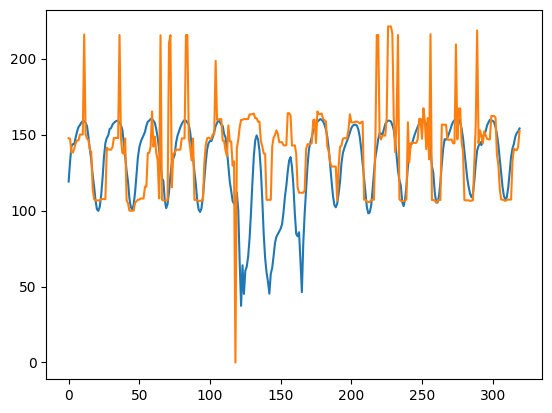

In [436]:
plt.plot(preds)
plt.plot(real)